In [1]:
using Random
using LabelledArrays
using OrdinaryDiffEq

using Catlab.CategoricalAlgebra, Catlab.Theories, Catlab.Graphs
using Catlab, Catlab.Programs
import Catlab.Programs: RelationalPrograms
using Catlab.WiringDiagrams, Catlab.Graphics
import Catlab.Graphics: Graphviz

using AlgebraicPetri
import AlgebraicPetri: Graph

using Plots

In [2]:
# References:
# easy:    https://github.com/epirecipes/sir-julia/blob/master/markdown/pn_algebraicpetri/pn_algebraicpetri.md
# meadium: https://algebraicjulia.github.io/AlgebraicPetri.jl/dev/examples/covid/epidemiology/
# hard:    https://www.algebraicjulia.org/blog/post/2020/10/structured-cospans/

In [3]:
# Define helper functions

#visualize categorical representation of undirected wiring diagram (uwd),
# used for @relation instances which define an uwd.
display_uwd(ex) = to_graphviz(
    ex,
    box_labels=:name,
    junction_labels=:variable,
    edge_attrs=Dict(:len=>".75")
);

#visualize categorical representation box diagram
show_diagram(d::WiringDiagram) = to_graphviz(d,
    orientation=LeftToRight,
    labels=true,
    label_attr=:xlabel,
    node_attrs=Graphviz.Attributes(:fontname => "Courier",),
    edge_attrs=Graphviz.Attributes(:fontname => "Courier",)
);

#Transition:
# Generates an OpenLabelledPetriNet which represents a spontaneous transition
# named `z` which changes a token from state `x` to state `y`.
#Used for:
# project in state x spontaneously moves to state y.
spontaneous_petri(x::Symbol, y::Symbol, z::Symbol) =
    Open(LabelledPetriNet(unique([x,y]), z=>(x, y)))

exposure_petri (generic function with 1 method)

In [4]:
# Define energy interactions
# Each of them is a multi-cospan object,
# where each state in the building block is a leg in the cospan.

# There are three different states:
# 1. dorment :D
# 2. active :A
# 3. exhausted :E

construction = spontaneous_petri(:D, :A, :constr);
depletion = spontaneous_petri(:A, :E, :depl);

In [5]:
# To integrate with the relational programs syntax provided by Catlab.jl
# we simply need to provided a dictionary to connect our new building
# blocks to labels of their domain specific semantics.

stages_dict = Dict(
    :construction=>construction,
    :depletion=>depletion,
)

# convert the categorical definition of possible transitions to the Petri net representation
oapply_energy(ex, args...) = oapply(ex, stages_dict, args...)

oapply_energy (generic function with 1 method)

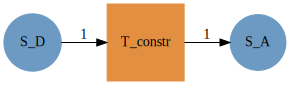

In [6]:
Graph(construction)

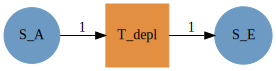

In [7]:
Graph(depletion)

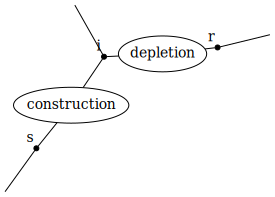

In [11]:
# Define model

wiring_diagram = @relation (s, i, r) begin
    construction(s, i)
    depletion(i, r)
end
display_uwd(wiring_diagram)

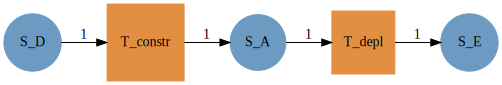

In [12]:
petri_net = apex(oapply_energy(wiring_diagram));
Graph(petri_net)

In [9]:
# Set time range
tmax = 40.0;
tspan = (0.0, tmax);

# Set population
u0 = LVector(S=990.0, I=10.0, R=0.0)
nr_people = sum(u0)

# Set parameter values
alpha = 0.05;  # construction rate
beta = 10.0;  # completion rate
gamma = 0.25;  # aging rate
p = LVector(inf=(beta*c/nr_people), rec=gamma);

# Fix random seed
Random.seed!(1234);

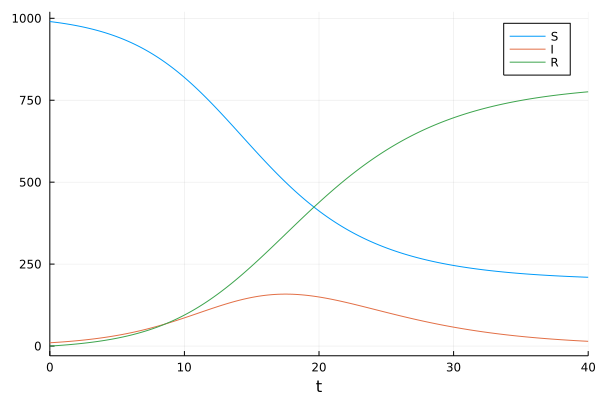

In [10]:
# The C-Set representation has direct support for generating a DiffEq vector field

prob_ode = ODEProblem(
    vectorfield(sir_model),
    u0, tspan, p,
);
sol_ode = solve(prob_ode, Tsit5());
plot(sol_ode)